In [1]:
#imports
import io
import pandas as pd
import numpy as np
import scipy as sci

from sklearn.preprocessing import MinMaxScaler # found in the scikit-learn package
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import SGD
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# The path where the CSV file is located
# Use your own path
path = "green-thai-curry-sales.csv"

# Read the CSV file and store it as a pandas DataFrame
df = pd.read_csv(path)
df = df['Sales']

df.index = df.index + 1 #Initialize the index at 1

# Lag the data frame
data = pd.concat([df.shift(1), df.shift(2), df.shift(3), df], axis=1)
data.columns = ['x1','x2', 'x3', 'y']
data = data.iloc[4:,]
data.head()


,x1,x2,x3,y
5,263.0,309.0,301.0,279
6,279.0,263.0,309.0,326
7,326.0,279.0,263.0,291
8,291.0,326.0,279.0,315
9,315.0,291.0,326.0,342


In [3]:
# Pick 80% of the data but keeps the original sequence (R)
train = data[:int(data.shape[0]*0.8)]
test = data[int(data.shape[0]*0.8):]

# Clean data in case of missing data
data = data.dropna()
train = train.dropna()
test = test.dropna()

In [4]:
# Calculate parameter for scaling back the outcome variable, both for the prediction and the actual values
ytrain_min = float(train.min()['y'])
ytrain_max = float(train.max()['y'])
ytrain_range = ytrain_max - ytrain_min

ytest_min = float(test.min()['y'])
ytest_max = float(test.max()['y'])
ytest_range = ytest_max - ytest_min

In [5]:
# Normalize the data frame
def scale(data):
    scaled_data = data.copy()
    for column in data.columns: 
      scaled_data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    return scaled_data

In [6]:
# Scale back the data frame
def scale_back(data, data_min, data_range):
    data_ = data.copy()
    data_.head()
    for column in data_.columns: 
        data_[column] = (data_range) * data_[column] + data_min
    return data_

In [7]:
# Normalize the train data in the range of 0-1
train_ = scale(train)

In [8]:
# Normalize the test data in the range of 0-1
test_ = scale(test)
test_

,x1,x2,x3,y
2921,0.239915,0.263270,0.239915,0.295117
2922,0.295117,0.239915,0.263270,0.343949
2923,0.343949,0.295117,0.239915,0.409766
2924,0.409766,0.343949,0.295117,0.363057
2925,0.363057,0.409766,0.343949,0.242038
...,...,...,...,...
3646,0.352442,0.371550,0.288747,0.348195
3647,0.348195,0.352442,0.371550,0.341826
3648,0.341826,0.348195,0.352442,0.392781
3649,0.392781,0.341826,0.348195,0.375796


In [9]:
# Separate the input (x) and output (y)
n = train_.columns                                    #column labels
xtrain = train_.filter(items = ['x1','x2','x3'])  #input of the training set
ytrain = train_.filter(items = ['y'])                    #output of the training set

xtest = test_.filter(items = ['x1','x2','x3'])  #input of the test set
ytest = test_.filter(items = ['y'])                    #output of the test set

ytest.head()

,y
2921,0.295117
2922,0.343949
2923,0.409766
2924,0.363057
2925,0.242038


In [10]:
# Train a neural network model
# https://www.tensorflow.org/api_docs/python/tf/keras/activations
model = Sequential()

# First add a layer with 3 neurons for 3 input variables (3 lags)
# and the RELU activation function
model.add(Dense(3, input_dim=3, activation='relu'))

# Then add a hidden layer with 8 neurons
# and the sigmoid activation function
model.add(Dense(8, activation='sigmoid'))

# Then add the output layer with 1 neuron
# and the RELU activation function
model.add(Dense(1, activation='relu'))
model.build((None, 3))
model.summary()
print(model.count_params())

opt = Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=opt, metrics=['mean_squared_error'])
model.fit(x=xtrain,y=ytrain, epochs=500, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
53


In [11]:
# Use the model to calculate predictions for the train set
y_pred = model.predict(xtrain)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns =['y'] 

In [12]:
# Scale back the predictions and original values
y_pred_rescaled = scale_back(pd.DataFrame(y_pred), ytrain_min, ytrain_range)
y_pred_rescaled.columns =['y'] 
y_train_rescaled = scale_back(pd.DataFrame(ytrain), ytrain_min, ytrain_range)
y_train_rescaled.head()

,y
5,279.0
6,326.0
7,291.0
8,315.0
9,342.0


In [13]:
# r-squared
r2_squared = r2_score(y_train_rescaled, y_pred_rescaled)
print('R-squared score of the train set:', round(r2_squared,4))

# mean squared error
mse = mean_squared_error(y_train_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print('Root mean squared error of the train set:', round(rmse,4))

# AIC
# trainable_weights includes neuron weights and biases
param_num = model.count_params()
print("Total number of parameters: ", param_num)
aic = train.shape[0] * np.log(mse) + 2*param_num
print("Akaike Information Criterion:", round(aic, 4))

R-squared score of the train set: 0.4308
Root mean squared error of the train set: 44.2152
Total number of parameters:  53
Akaike Information Criterion: 22203.8467


In [14]:
# Use the model to calculate predictions for the test set
y_pred = model.predict(xtest)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns =['y'] 
y_pred_df.head()

,y
0,0.252439
1,0.292960
2,0.296717
3,0.325937
4,0.339758


In [15]:
# Scale back the predictions and original values for the test set
y_pred_rescaled = scale_back(pd.DataFrame(y_pred), ytest_min, ytest_range)
y_pred_rescaled.columns =['y'] 
y_test_rescaled = scale_back(pd.DataFrame(ytest), ytest_min, ytest_range)
y_test_rescaled.head()

,y
2921,367.0
2922,390.0
2923,421.0
2924,399.0
2925,342.0


In [16]:
# r-squared with test set
r2_squared = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score of the test set:', round(r2_squared,4))

# mean squared error with the test set
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print('Root mean squared error of the test set:', round(rmse,4))

R-squared score of the test set: 0.4007
Root mean squared error of the test set: 41.663


Text(0.5, 1.0, 'Scatter plot of predicted vs actual data')

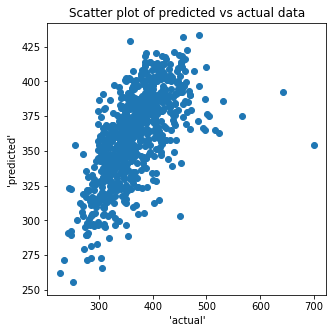

In [17]:
# Generate a scatter plot of predicted vs actual data
plt.figure(figsize=(5,5))
plt.scatter(x = y_test_rescaled, y = y_pred_rescaled)
plt.xlabel("'actual'")
plt.ylabel("'predicted'")
plt.title("Scatter plot of predicted vs actual data")

In [18]:
# Add a time column for plotting purposes
y_test_rescaled['time'] = y_test_rescaled.index
y_test_rescaled = y_test_rescaled.sort_values(by=['time'])
y_actual = pd.DataFrame(y_test_rescaled['y'])
y_actual.reset_index(drop=True, inplace=True)

y_pred_rescaled['time'] = y_test_rescaled.index
y_pred_rescaled = y_pred_rescaled.sort_values(by=['time'])
y_hat = pd.DataFrame(y_pred_rescaled['y'])
y_hat.reset_index(drop=True, inplace=True)

time = y_test_rescaled['time']

# To export the predictions and test values to a CSV file
df.to_csv(r'predictions-green-thai-curry.csv', index = False)
y_test_rescaled.to_csv(r'ytest.csv', index = False)
y_pred_rescaled.to_csv(r'yhat.csv', index = False)

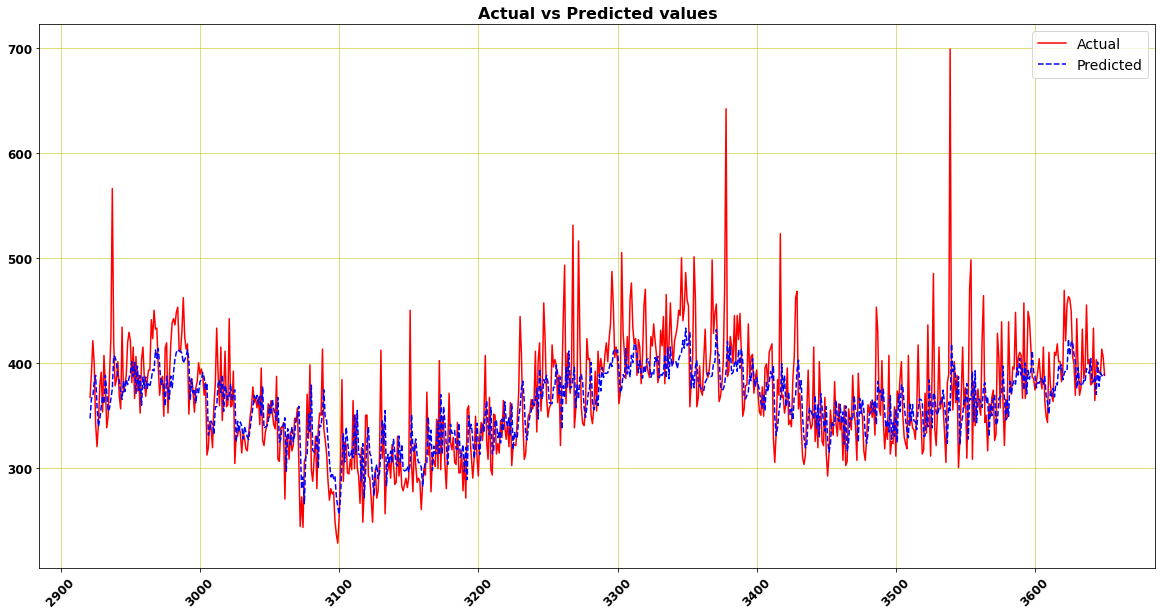

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(time, y_actual, linestyle='solid', color='r')
plt.plot(time, y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('Actual vs Predicted values', weight='bold', fontsize=16)
#plt.ylabel('demand', weight='bold', fontsize=14)
#plt.xlabel('time', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()